In [51]:
import glob
import joblib
import imageio
from os import path
from os import mkdir

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import randint
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from collections import Counter

from keras import layers
from keras import models
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf

import util

# __Binary Classification with Imbalanced Dataset__

## __Abstract__
***

In classification, when the number of examples that represent one class is much lower than other classes, the dataset is said to be __imbalanced__.  This problem is one of the challenging problems both in data mining research and real-world application (Yang, 2005). In this project, our aim is to gain experience working with a dataset that suffers from this problem. We take the Intel Image dataset (https://www.kaggle.com/puneet6060/intel-image-classification) and construct an imbalance dataset suitable for a __binary classification__ task (see preprocessing steps). We build various classifiers including linear, nonlinear, ensemble methods, and neural networks to model this dataset. To compare the performance of these classifiers, we plot their ROC curves and compute their AUCs. 

## __Data__
***

__Name__: Intel Image Scene (https://www.kaggle.com/puneet6060/intel-image-classification) <br>
__Data__: $150\times150\times3$ RGB images distributed over 6 classes <br>
__Classes__: building, street, forest, glacier, mountain, sea <br>

![Image Classes](img/intel_image_classes.png)

We begin by fetching the training and test sets using our utility function <code>util.get_dataset</code>. Refer to <code>util.py</code> for the source code. 

In [2]:
X_train, Y_train = util.get_dataset(folder='train')
X_test, Y_test = util.get_dataset(folder='test')

The number of images in the training and test sets are printed below. Each RGB image is stored as a $150\times150\times3$ array. Note that a RGB image has three channels: red, green and blue. Each channel use 8 bits, which have integer values from $0$ ot $255$. 

In [3]:
print("Dimension of training set is", X_train.shape)
print("Dimension of test set is", X_test.shape)
print("The training set contains %d images" % X_train.shape[0])
print("The test set contains %d images" % X_test.shape[0])

Dimension of training set is (13986, 150, 150, 3)
Dimension of test set is (2993, 150, 150, 3)
The training set contains 13986 images
The test set contains 2993 images


Below, we see that the $6$ classes (buildings, street, forest, glacier, mountain and sea) are evenly distributed in our training set. This is also true for the test set. 

In [4]:
# Print the number of instances for each class from the training set
counter = Counter(Y_train)
for i,label in [(1, 'building'), (2, 'street'), (3, 'forest'), (4, 'glacier'), (5, 'mountain'), (6, 'sea')]:
    print("Class %s has %d instances" % (label, counter[i]))

Class building has 2190 instances
Class street has 2381 instances
Class forest has 2263 instances
Class glacier has 2387 instances
Class mountain has 2495 instances
Class sea has 2270 instances


To get a quick feel of our data, let's plot $5$ images from each class. 

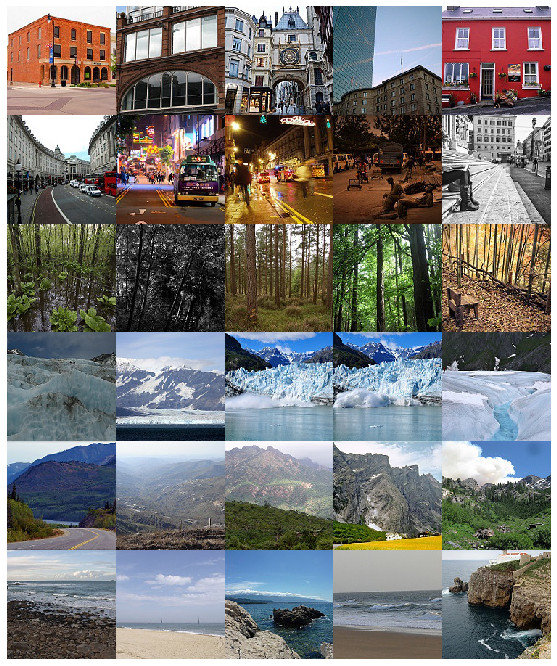

In [5]:
# Plot 5 images from each class
plt.figure(figsize=(10,12))
example_images = np.r_[X_train[10:15], X_train[2225:2230],X_train[4580:4585], X_train[6885:6890], X_train[9260:9265], X_train[11800:11805]]
util.plot_digits(example_images, images_per_row=5)
plt.show()

## __Preprocessing Steps__
***

We apply the following preprocessing steps to our dataset:
- Prepare data for binary classification
- Balance the dataset
- Flatten each image and normalize each pixel value
- Create validation set
- Apply PCA

### __Prepare Data For Binary Classification__

To prepare our data for binary classification, we will create two new classes: __city__ and __not city__. Instances from the original dataset belonging to the class __buildings__ and __streets__ will make up the __city__ class. While the remaining classes (__forest__, __glacier__, __mountain__, __sea__) will make up the __not city__ class. 

Below, we assign label $1$ to denote the __city__ class, and label $0$ for the __not city__ class.

In [6]:
# Assign label 1 to buildings and street images; label 0 otherwise.
Y_train = np.where(Y_train == 2, 1, Y_train)
Y_train = np.where(Y_train != 1, 0, Y_train)
Y_test = np.where(Y_test == 2, 1, Y_test)
Y_test = np.where(Y_test != 1, 0, Y_test)

![Image Classes](img/intel_image_binary_classes.png)

However, our new dataset for binary classification is imbalanced. The number of __city__ images is smaller than the number of __not city__ images. Below, we show that class __city__ only makes up $33\%$ of the training set. The same class distribution is also evident in the test set.

In [7]:
# Show that our dataset for binary classification is imbalanced
counter = Counter(Y_train)
label_1_percentage = counter[1]/ (counter[0] + counter[1]) * 100
print("Label 1 has %s instances" % counter[1])
print("Label 0 has %s instances" % counter[0])
print("Class city only makes up %0.f%% of the dataset" % label_1_percentage)

Label 1 has 4571 instances
Label 0 has 9415 instances
Class city only makes up 33% of the dataset


### __Balance the Dataset__

In the previous section, we showed that our dataset for binary classification is imbalanced. This could be a problem. Most standard machine learning algorithms expect balanced class distribution or an equal misclassification cost (He and Garcia, 2009). Approaches to the class imbalance problem can be categorized in three groups (Galar et al., 2011):
- __Algorithm level__: adapts existing classifiers to bias the learning toward the underrepresented class (e.g. Setting the parameter <code>class_weight='balanced'</code> in scikit-learn's <code>LogisticRegression</code>). 
- __Data level__: rebalance the class distribution by resampling the data space (e.g. random oversampling and undersampling, SMOTE, data augmentation). 
- __Cost sensitive learning framework__: combination of data and algorithm level approaches.

To deal with our imbalanced dataset, we will make use of __data augmentation__ to expand the size of the training set by creating modified versions of images belonging to the minority class. In our dataset, the underrepresented class is __city__.  To create plausible examples of this class, we simply take the __horizontal flip__ of __city__ images in our training set. 

In the code below, we flip each __city__ images horizontally and save them in the folder <code>dataset/flipped_images</code>. We then read these image and add them as part of our training set. 

In [8]:
# Flip each city image horizontally and save them in dataset/flipped_images
flipped_dir = path.join('dataset', 'flipped_images')
city_dir = path.join(flipped_dir, 'city')
if not path.exists(flipped_dir):
    mkdir(flipped_dir)
    mkdir(city_dir)
    indices = np.where(Y_train == 1)[0]
    for i in indices:
        flipped_img = np.fliplr(X_train[i])
        filename = os.path.join(city_dir, 'flipped_' + str(i) + '.jpg')
        imageio.imwrite(filename, flipped_img)

# Add flipped images to training set
X_flipped, Y_flipped = util.get_dataset(folder='flipped_images')
X_train = np.r_[X_train, X_flipped]
Y_train = np.r_[Y_train, Y_flipped]

Let's take a look at some images and their horizontal flipped counterparts. 

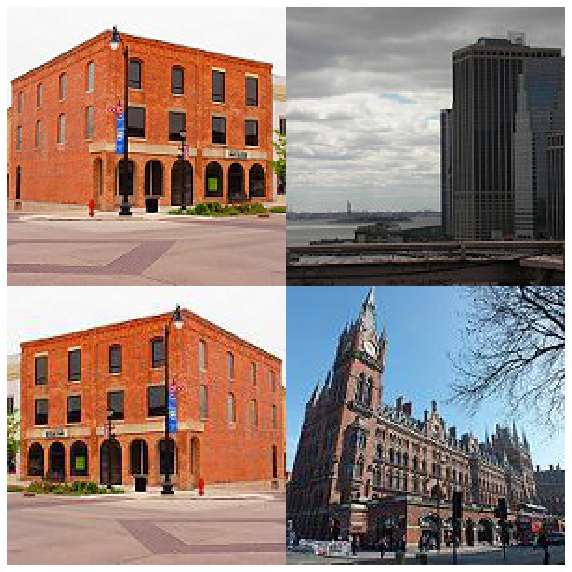

In [9]:
plt.figure(figsize=(10,12))
example_images = np.r_[X_train[10:11], X_train[1007:1008], X_train[13988:13989], X_train[13997:13998]]
util.plot_digits(example_images, images_per_row=2)
plt.show()

The number of __city__ images is now roughly equivalent to the number of __not city__ images. Note the new size of the training set, which is printed below.

In [10]:
counter = Counter(Y_train)
label_1_percentage = counter[1]/ (counter[0] + counter[1]) * 100
print("Label 1 has %s instances" % counter[1])
print("Label 0 has %s instances" % counter[0])
print("Class city now makes up %0.f%% of the dataset" % label_1_percentage)
print("The size of the training set with augmented images is", len(X_train))

Label 1 has 9142 instances
Label 0 has 9415 instances
Class city now makes up 49% of the dataset
The size of the training set with augmented images is 18557


### __Flatten Each Image__

Next, we transform our dataset into a form expected by Scikit-Learn's machine learning algorithms. Each RGB image in our dataset is a 3D tensor with dimension $150\times150\times3$. We flatten this 3D tensor to a 1D array of size $67500$. Each RGB channel uses 8-bits to encode pixel values. Therefore, we can normalize the pixel values by dividing it by $255$. 

In [11]:
# Flatten each image
N_train = X_train.shape[0]
N_test = X_test.shape[0]
X_train = np.reshape(X_train, (N_train, -1))
X_test = np.reshape(X_test, (N_test, -1))

# Scale pixel values between 0 and 1.0
X_train = np.divide(X_train, 255.0).astype(np.float32)
X_test = np.divide(X_test, 255.0).astype(np.float32)

Below, we check the new dimensions of the training and test set as a result of flattening

In [12]:
print("The dimensions of the training set is now", X_train.shape)
print("The dimensions of the test set is now", X_test.shape)

The dimensions of the training set is now (18557, 67500)
The dimensions of the test set is now (2993, 67500)


### __Create Validation Set__

In the sections that follow, we will be building various classifiers. The metric that we will use to assess the performance of these classifiers is the __Receiver Operating Characteristics (ROC) graph__. A ROC graph is a technique for visualizing and selecting classifiers based on their performance (Fawcett, 2004). It is a two-dimensional plot of a classifier's __false positive rate__ (fpr) against __true positive rate__ (tpr) (Provost and Fawcett, 2013): 

$$\text{tpr} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Negative}}$$
$$\text{fpr} = \frac{\text{False Positive}}{\text{False Positive} + \text{True Negative}}$$

To compute these quantities, we will need a __validation set__. That is, a classifier will be trained on the training set and evaluated using the ROC on the validation set. Below, we create a validation out of the original training set. 

In [13]:
# Shuffle
X_train, Y_train = shuffle(X_train, Y_train, random_state=42)
X_test, Y_test = shuffle(X_test, Y_test, random_state=42)

# Create validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, stratify=Y_train, random_state=42)

The dimensions of the new training set and validation set are printed below.

In [14]:
print("The dimensions of the training set is", X_train.shape)
print("The dimensions of the validation set is", X_val.shape)

The dimensions of the training set is (13917, 67500)
The dimensions of the validation set is (4640, 67500)


### __Apply PCA__

The number of attributes for each image in our dataset is $67500$. To reduce this number, we compute the principal components of the training set and take only the attributes that explains $95\%$ of the variance. These attributes will make up the reduced training set and reduced validation set denoted as <code>X_train_reduced</code> and <code>X_val_reduced</code>, respectively.

In [15]:
# Reduce the number of attributes via PCA

# Filename for the reduced validation set
filename_X_val_reduced = path.join('results', 'X_val_reduced.npy')

# Filenames for reduced training set
# Note: Reduced training set was saved in three separate files to accomodate
#       GitHub's file size limit. 
filename_X_train_reduced_part_1 = path.join('results', 'X_train_reduced_part_1.npy')
filename_X_train_reduced_part_2 = path.join('results', 'X_train_reduced_part_2.npy')
filename_X_train_reduced_part_3 = path.join('results', 'X_train_reduced_part_3.npy')

if path.exists(filename_X_train_reduced_part_1) \
    and path.exists(filename_X_train_reduced_part_2) \
    and path.exists(filename_X_train_reduced_part_3) \
    and path.exists(filename_X_val_reduced):
    # Load X_train_reduced and X_val_reduced
    X_train_reduced = np.r_[np.load(filename_X_train_reduced_part_1), 
                            np.load(filename_X_train_reduced_part_2), 
                            np.load(filename_X_train_reduced_part_3)]
    X_val_reduced = np.load(filename_X_val_reduced)
else:
    # Perform PCA on the training set
    pca = PCA(n_components = 0.95, random_state=42)
    X_train_reduced = pca.fit_transform(X_train)
    X_val_reduced = pca.transform(X_val)
    # Save the results
    block = int(len(X_train_reduced)/3)
    np.save(filename_X_train_reduced_part_1, X_train_reduced[0:block])
    np.save(filename_X_train_reduced_part_2, X_train_reduced[block:2*block])
    np.save(filename_X_train_reduced_part_3, X_train_reduced[2*block:3*block])
    np.save(filename_X_val_reduced, X_val_reduced)

The dimensions of the reduced training and validation sets are printed below.

In [16]:
print("The dimension of the reduced training set is", X_train_reduced.shape)
print("The dimension of the reduced validation set is", X_val_reduced.shape)

The dimension of the reduced training set is (13917, 4120)
The dimension of the reduced validation set is (4640, 4120)


## __Modelling__
***

Using the reduced training set <code>X_train_reduced</code> and validation set <code></code>, we build the following classifiers:
- logistic regression
- linear svm
- decision tree
- Ensemble method
    - bagging: random forest
    - boosting: adaptive boost and gradient boost 
- Neural Network

### __Logistic Regression__
The <code>SGDClassifier</code> object with parameter <code>loss='log'</code> is logistic regression where the optimization method used is stochastic gradient descent. 

In [17]:
# The file "logistic_confidence_scores.npy" contains the confidence scores necessary
# to compute the ROC graph.

filename = path.join('results', 'logistic_confidence_scores.npy')
if path.exists(filename):
    # Load the confidence scores
    confidence_scores = np.load(filename)
else:
    # Fit the logistic model and save the confidence scores
    model = SGDClassifier(loss='log', random_state=42)
    model.fit(X_train_reduced, Y_train)
    probas = model.predict_proba(X_val_reduced)
    confidence_scores = probas[:,1]
    np.save(filename, confidence_scores)

# Compute fpr and tpr
logistic_fpr, logistic_tpr, thresholds = roc_curve(Y_val, confidence_scores)

Below we plot the ROC curve for the logistic regression classifier.

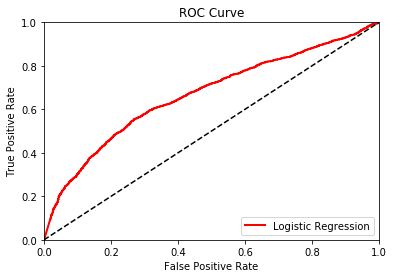

In [18]:
util.plot_roc_curve([logistic_fpr], [logistic_tpr], ['Logistic Regression'], ['red'])

Before we proceed, it's important to note several points in the ROC plot (Fawcett, 2014):
- The point (0,0) represents the classifier that _never_ issues positive classification.
- The point (1,1) represents the classifier that _always_ issues positive classification.
- The point (0,1) represents the perfect classifier.
- The diagonal dashed line connecting (0,0) and (1,1) represents the classifier that simply does random guessing. 
- The __area under the curve__ (AUC) represents the average performance of the classifier and is a useful quantity for comparing the performance of different models. __An AUC of 1.0 is a perfect classifier__. 

Let's compute the AUC of the logistic regression classifier below.

In [19]:
logistic_auc_score = roc_auc_score(Y_val, confidence_scores)
print("The AUC for the logistic regression classifier is %0.2f" % logistic_auc_score)

The AUC for the logistic regression classifier is 0.67


### __Support Vector Machine__

The <code>SGDClassifier</code> object with parameter <code>loss='hinge'</code> is linear svm where the optimization method used is stochastic gradient descent. 

In [20]:
# The file "svm_confidence_scores.npy" contains the confidence scores necessary
# to compute the ROC graph.

filename = path.join('results', 'svm_confidence_scores.npy')
if path.exists(filename):
    # Load the confidence scores
    confidence_scores = np.load(filename)
else:
    # Fit the linear svm model and save the confidence scores
    model = SGDClassifier(loss='hinge', random_state=42)
    model.fit(X_train_reduced, Y_train)
    confidence_scores = model.decision_function(X_val_reduced)
    np.save(filename, confidence_scores)
    
svm_fpr, svm_tpr, _ = roc_curve(Y_val, confidence_scores)
svm_auc_score = roc_auc_score(Y_val, confidence_scores)

Let's plot the ROC curves of both logistic regression and linear svm. Also, print the their corresponding AUC. 

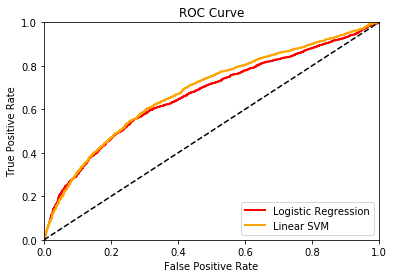

AUC
Logistic Regression: 0.67
Linear SVM: 0.69


In [21]:
util.plot_roc_curve([logistic_fpr, svm_fpr], 
                    [logistic_tpr, svm_tpr], 
                    ['Logistic Regression', 'Linear SVM'], 
                    ['red', 'orange'])
print("AUC")
print("Logistic Regression: %0.2f" % logistic_auc_score)
print("Linear SVM: %0.2f" % svm_auc_score)

### __Decision Tree__

Before we model a decision tree and plot its ROC curve, let us find a good value for the <code>max_depth</code> parameter of <code>DecisionTree</code> when training on our dataset.

In [22]:
# The file "random_search_for_tree.pkl" contains the results of running
# RandomizedSearchCV to find the optimal max_depth parameter for DecisionTree.

filename = path.join('results', 'random_search_for_tree.pkl')
if path.exists(filename):
    # Load result of RandomizedSearchCV
    random_search = joblib.load(filename)
else:
    # Run RandomizedSearchCV
    param_distributions = {'max_depth' : randint(5,100)}
    model = DecisionTreeClassifier()
    random_search = RandomizedSearchCV(model, param_distributions=param_distributions,
                                       n_iter=50, cv=3, scoring='roc_auc',
                                       verbose=3, n_jobs=3, random_state=42)
    random_search.fit(X_train_reduced, Y_train)
    joblib.dump(random_search, filename)

Below, we print the result of the hyperparameter tuning and fit a decision tree with the optimal value of <code>max_depth</code>.

In [23]:
print("The optimal max_depth is", random_search.best_params_['max_depth'])

The optimal max_depth is 6


In [24]:
# The file "tree_confidence_scores.npy" contains the confidence scores necessary
# to compute the ROC graph.

filename = path.join('results', 'tree_confidence_scores.npy')
if path.exists(filename):
    # Load the confidence scores
    confidence_scores = np.load(filename)
else:
    # Fit the decision tree model and save the confidence scores
    model = DecisionTreeClassifier(max_depth=random_search.best_params_['max_depth'],
                                   random_state=42)
    model.fit(X_train_reduced, Y_train)
    probas = model.predict_proba(X_val_reduced)
    confidence_scores = probas[:,1]
    np.save(filename, confidence_scores)
    
tree_fpr, tree_tpr, _ = roc_curve(Y_val, confidence_scores)
tree_auc_score = roc_auc_score(Y_val, confidence_scores)

Next, we plot the ROC curve of logistic regression, linear svm and decision tree and print their AUC. 

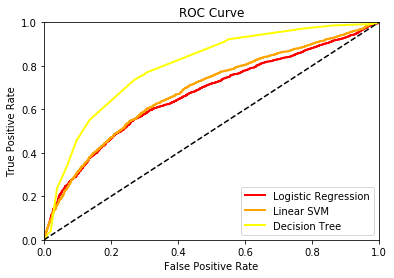

AUC
Logistic Regression: 0.67
Linear SVM: 0.69
Decision Tree: 0.80


In [25]:
util.plot_roc_curve([logistic_fpr, svm_fpr, tree_fpr], 
                    [logistic_tpr, svm_tpr, tree_tpr], 
                    ['Logistic Regression', 'Linear SVM', 'Decision Tree'], 
                    ['red', 'orange', 'yellow'])
print("AUC")
print("Logistic Regression: %0.2f" % logistic_auc_score)
print("Linear SVM: %0.2f" % svm_auc_score)
print("Decision Tree: %0.2f" % tree_auc_score)

### __Random Forest Classifier__

Scikit-Learn's <code>RandomForestClassifier</code> is a bagging ensemble algorithm where the weak learner is a <code>DecisionTree</code>. Below, we find the optimal values for the following parameters: <code>n_estimators</code>, <code>max_features</code> and <code>max_depth</code>. 

In [26]:
# The file "random_search_for_random_forest.pkl" contains the results of running
# RandomizedSearchCV to find the optimal n_estimators, max_features and max_depth 
# parameters for RandomForestClassifier.

filename = path.join('results', 'random_search_for_random_forest_roc.pkl')
if path.exists(filename):
    # Load result of RandomizedSearchCV
    random_search = joblib.load(filename)
else:
    # Run RandomizedSearchCV
    default_n_estimators = 100
    default_max_features = np.sqrt(len(X_train_reduced[0]))
    param_distributions = {'n_estimators' : randint(default_n_estimators/2,
                                                    default_n_estimators*2), 
                           'max_features' : randint(default_max_features/2, 
                                                    default_max_features*2), 
                           'max_depth' : randint(1,25)}
    model = RandomForestClassifier(verbose=1)
    random_search = RandomizedSearchCV(model, param_distributions=param_distributions,
                                       n_iter=150, cv=3, scoring='roc_auc',
                                       verbose=3, n_jobs=5, random_state=42)
    random_search.fit(X_train_reduced, Y_train)
    joblib.dump(random_search, filename)

Print the result of the hyperparameter tuning.

In [27]:
random_search.best_params_

{'max_depth': 15, 'max_features': 125, 'n_estimators': 193}

Using the result of the hyperparameter tuning above, fit a <code>RandomForestClassifier</code> on our training set. 

In [28]:
# The file "random_forest_confidence_scores.npy" contains the confidence scores necessary
# to compute the ROC graph.

filename = path.join('results', 'random_forest_confidence_scores.npy')
if path.exists(filename):
    # Load the confidence scores
    confidence_scores = np.load(filename)
else:
    # Fit RandomForestClassifier 
    model_tuned = RandomForestClassifier(n_estimators=random_search.best_params_['n_estimators'], 
                                         max_features=random_search.best_params_['max_features'],
                                         max_depth=random_search.best_params_['max_depth'],
                                         random_state=42)
    model_tuned.fit(X_train_reduced, Y_train)
    probas = model_tuned.predict_proba(X_val_reduced)
    confidence_scores = probas[:,1]
    np.save(filename, confidence_scores)

randomForest_fpr, randomForest_tpr, _ = roc_curve(Y_val, confidence_scores)
randomForest_auc_score = roc_auc_score(Y_val, confidence_scores)

Plot the ROC curves of logistic regression, linear svm, decision tree and random forest classifier. 

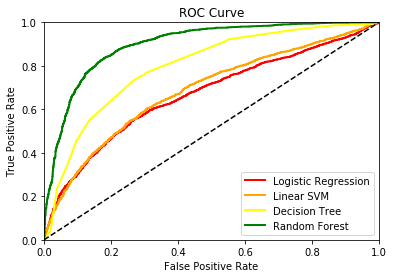

AUC
Logistic Regression: 0.67
Linear SVM: 0.69
Decision Tree: 0.80
Random Forest: 0.90


In [29]:
util.plot_roc_curve([logistic_fpr, svm_fpr, tree_fpr, randomForest_fpr], 
                    [logistic_tpr, svm_tpr, tree_tpr, randomForest_tpr], 
                    ['Logistic Regression', 'Linear SVM', 'Decision Tree', 'Random Forest'], 
                    ['red', 'orange', 'yellow', 'green'])
print("AUC")
print("Logistic Regression: %0.2f" % logistic_auc_score)
print("Linear SVM: %0.2f" % svm_auc_score)
print("Decision Tree: %0.2f" % tree_auc_score)
print("Random Forest: %0.2f" % randomForest_auc_score)

Stopped running here...

### __Adaptive Boosting__

Scikit-Learn's <code>AdaBoostClassifier</code> is a boosting ensemble algorithm where the weak learners are trained sequentially to improve the mistakes of the previous weak learner. Here, we will use <code>DecisionTree</code> as the weak learner. 

In [30]:
# The file "adaboost_forest_confidence_scores.npy" contains the confidence scores necessary
# to compute the ROC graph.

filename = path.join('results', 'adaboost_forest_confidence_scores.npy')
if path.exists(filename):
    # Load the confidence scores
    confidence_scores = np.load(filename)
else:
    # Fit AdaBoostClassifier with DecisionTreeClassifier as weak learner
    model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), 
                               n_estimators=200, 
                               algorithm='SAMME.R', 
                               random_state=42)
    model.fit(X_train_reduced, Y_train)
    probas = model.predict_proba(X_val_reduced)
    confidence_scores = probas[:,1]
    np.save(filename, confidence_scores)

adaBoostForest_fpr, adaBoostForest_tpr, _ = roc_curve(Y_val, confidence_scores)
adaBoostForest_auc_score = roc_auc_score(Y_val, confidence_scores)

Plot the ROC curves of logistic regression, linear svm, decision tree, random forest classifier, and adaboost. 

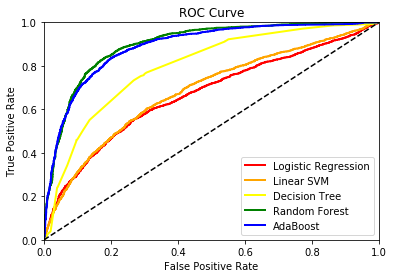

AUC
Logistic Regression: 0.67
Linear SVM: 0.69
Decision Tree: 0.80
Random Forest: 0.90
AdaBoost: 0.89


In [31]:
util.plot_roc_curve([logistic_fpr, svm_fpr, tree_fpr, randomForest_fpr, adaBoostForest_fpr], 
                    [logistic_tpr, svm_tpr, tree_tpr, randomForest_tpr, adaBoostForest_tpr], 
                    ['Logistic Regression', 'Linear SVM', 'Decision Tree', 'Random Forest', 'AdaBoost'], 
                    ['red', 'orange', 'yellow', 'green', 'blue'])
print("AUC")
print("Logistic Regression: %0.2f" % logistic_auc_score)
print("Linear SVM: %0.2f" % svm_auc_score)
print("Decision Tree: %0.2f" % tree_auc_score)
print("Random Forest: %0.2f" % randomForest_auc_score)
print("AdaBoost: %0.2f" % adaBoostForest_auc_score)

### __Gradient Boosting__

Scikit-Learn's <code>GradientBoostClassifier</code> is a boosting ensemble algorithm where the weak learners are <code>DecisionTree</code> and are trained sequentially to minimize the residual of sequential learners. 

In [32]:
# The file "gboost_forest_confidence_scores.npy" contains the confidence scores necessary
# to compute the ROC graph.

filename = path.join('results', 'gboost_forest_confidence_scores.npy')
if path.exists(filename):
    # Load confidence scores
    confidence_scores = np.load(filename)
else:
    # Fit GradientBoostingClassifier
    model = GradientBoostingClassifier(max_depth=3, n_estimators=200)
    model.fit(X_train_reduced, Y_train)
    probas = model.predict_proba(X_val_reduced)
    confidence_scores = probas[:,1]
    np.save(filename, confidence_scores)

gBoostForest_fpr, gBoostForest_tpr, _ = roc_curve(Y_val, confidence_scores)
gBoostForest_auc_score = roc_auc_score(Y_val, confidence_scores)

Plot the ROC curves of logistic regression, linear svm, decision tree, random forest classifier, adaboost and gradient boost. 

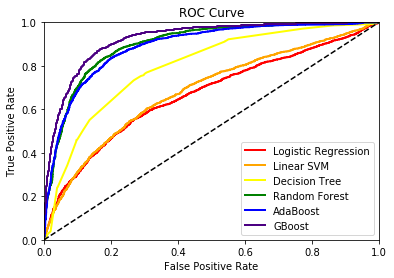

AUC
Logistic Regression: 0.67
Linear SVM: 0.69
Decision Tree: 0.80
Random Forest: 0.90
AdaBoost: 0.89
GBoost: 0.92


In [33]:
util.plot_roc_curve([logistic_fpr, svm_fpr, tree_fpr, randomForest_fpr, adaBoostForest_fpr, gBoostForest_fpr], 
                    [logistic_tpr, svm_tpr, tree_tpr, randomForest_tpr, adaBoostForest_tpr, gBoostForest_tpr], 
                    ['Logistic Regression', 'Linear SVM', 'Decision Tree', 'Random Forest', 'AdaBoost', 'GBoost'], 
                    ['red', 'orange', 'yellow', 'green', 'blue', 'indigo'])
print("AUC")
print("Logistic Regression: %0.2f" % logistic_auc_score)
print("Linear SVM: %0.2f" % svm_auc_score)
print("Decision Tree: %0.2f" % tree_auc_score)
print("Random Forest: %0.2f" % randomForest_auc_score)
print("AdaBoost: %0.2f" % adaBoostForest_auc_score)
print("GBoost: %0.2f" % gBoostForest_auc_score)

### __Neural Network__

To feed our images to a convolutional neural network, we have to reshape it to back to the dimension $150\times150\times3$

In [39]:
X_train_nn = np.reshape(X_train, (len(X_train), 150, 150, 3))
X_test_nn = np.reshape(X_test, (len(X_test), 150, 150, 3))
X_val_nn = np.reshape(X_val, (len(X_val), 150, 150, 3))

We borrow the following convolutional neural network from Chollet, 2018. It is a stack of alternated <code>Conv2D</code> with <code>relu</code> activation and <code>MaxPooling2D</code> layers. It starts with an input size of $150\times150$ and end with a <code>Dense</code> layer of size $1$ with a <code>sigmoid</code> activation. This final layer will yield the probability it assigns to each classes for prediction. 

In [52]:
# Set random seed for reproducible results
tf.set_random_seed(42)

def create_nn():
    """
       Build and compile a small CONVNET from Chollet, 2018
    """
    nn = models.Sequential()
    nn.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
    nn.add(layers.MaxPooling2D((2, 2)))
    nn.add(layers.Conv2D(64, (3, 3), activation='relu'))
    nn.add(layers.MaxPooling2D((2, 2)))
    nn.add(layers.Conv2D(128, (3, 3), activation='relu'))
    nn.add(layers.MaxPooling2D((2, 2)))
    nn.add(layers.Conv2D(128, (3, 3), activation='relu'))
    nn.add(layers.MaxPooling2D((2, 2)))
    nn.add(layers.Flatten())
    nn.add(layers.Dense(512, activation='relu'))
    nn.add(layers.Dense(1, activation='sigmoid'))
    
    nn.compile(loss='binary_crossentropy', 
               optimizer=optimizers.RMSprop(lr=1e-4), 
               metrics=['acc'])
    return nn

Firstly, let us find the number of epochs that will not overfit our CNN. We do this by seeing how our model performs across various epochs. Below, we run our model to fit upto 85 epochs. We then plot the accuracy and loss of our model over the training and validation sets. 

In [56]:
# The file "history_tuning_nn.pkl" contains history of fitting the model

filename = path.join('results', 'history_tuning_nn.pkl')
if path.exists(filename):
    # Load history
    history = joblib.load(filename)
else:
    # Fit the model and save results
    model = create_nn()
    history = model.fit(X_train_nn, Y_train, epochs=85, batch_size=256, validation_data=(X_val_nn, Y_val))    
    joblib.dump(history, filename)

# Extract accuracy and loss across epoch
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

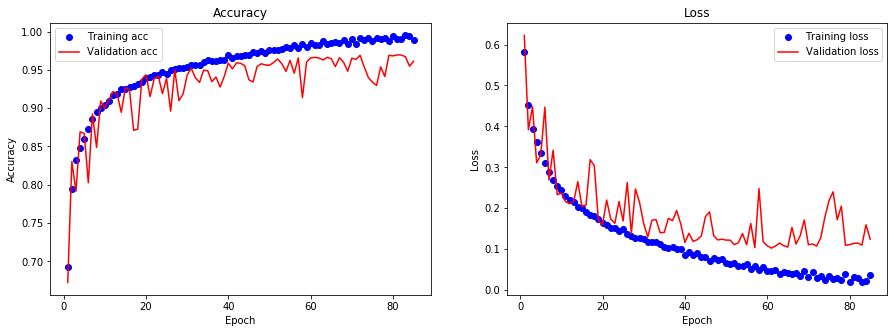

In [57]:
# Plot the accuracy of the training and validation sets
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot the loss of the training and validation sets
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

After $\text{epoch}\approx40$, both accuracy and loss show no improvements. Below, we fit the CNN using this epoch. 

In [59]:
# The file "nn_confidence_scores.npy" contains confidence scores
# necessary for computing the ROC curve.

filename = path.join('results', 'nn_confidence_scores.npy')
if path.exists(filename):
    # Load confidence scores
    confidence_scores = np.load(filename)
else:
    # Fit the CNN
    model = KerasClassifier(build_fn=create_nn, epochs=40, batch_size=256, verbose=2)
    model.fit(X_train_nn, Y_train)
    probas = model.predict_proba(X_val_nn)
    confidence_scores = probas[:,1]
    np.save(filename, confidence_scores)
    
nn_fpr, nn_tpr, _ = roc_curve(Y_val, confidence_scores)
nn_auc_score = roc_auc_score(Y_val, confidence_scores) 

Now we compare all of our classifiers using their ROC curves and AUCs. 

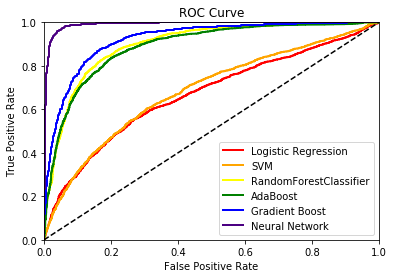

AUC
Logistic Regression: 0.67
Linear SVM:          0.69
Decision Tree:       0.80
Random Forest:       0.90
AdaBoost:            0.89
GBoost:              0.92
Neural Network       0.99


In [73]:
# Plot ROC
fprs = [logistic_fpr, svm_fpr, randomForest_fpr, adaBoostForest_fpr, gBoostForest_fpr, nn_fpr]
tprs = [logistic_tpr, svm_tpr, randomForest_tpr, adaBoostForest_tpr, gBoostForest_tpr, nn_tpr]
legend_labels = ['Logistic Regression', 'SVM', 'RandomForestClassifier', 'AdaBoost', 'Gradient Boost', 'Neural Network']
legend_colors = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet']
util.plot_roc_curve(fprs, tprs, legend_labels, legend_colors)
print("AUC")
print("Logistic Regression: %0.2f" % logistic_auc_score)
print("Linear SVM:          %0.2f" % svm_auc_score)
print("Decision Tree:       %0.2f" % tree_auc_score)
print("Random Forest:       %0.2f" % randomForest_auc_score)
print("AdaBoost:            %0.2f" % adaBoostForest_auc_score)
print("GBoost:              %0.2f" % gBoostForest_auc_score)
print("Neural Network       %0.2f" % nn_auc_score)

There are a few things to note about the results shown above. With AUC of less than $0.70$ the linear methods (logistic regression and linear svm) achieve the lowest AUC. In comparison, the decision tree classifier, which is non-linear, has a significantly higher AUC of $80\%$. This imply that the two classes in our dataset is not linearly separable. In other words, a single hyperplane is not a sufficient model for our binary classification problem. The ensemble methods (random forest, adaptive boose, gradient boost) perform very well with AUCs around $90\%$, leading to the general observation that forming tree-based ensemble methods leads to lower variance. With the exception of our small CNN, all of these methods were trained and evaluated on the reduced datasets, <code>X_train_reduced</code> and <code>X_val_reduced</code>, which were obtained via PCA. Performing the fits using the full $150\times150\times3$ images would be computationally expensive for these non-neural network models. Trained and evaluated on the full $150\times150\times3$ images, our small CNN, defined in <code>create_nn()</code>, achieves an AUC of 0.99 over the validation set. In the next section, we proceed to evaluate our small CNN on the test set.

## __Performance on Test Set__
***

The previous section shows that the CNN model defined in <code>create_nn()</code> is the best performing classifier for our binary classification problem. Below, we build the final version of our classifier that is to be evaluated on the test set. To do this, we perform the fit over all available dataset that is not part of the test set. 

In [74]:
X_train_nn = np.concatenate((X_train_nn, X_val_nn), axis=0)
Y_train = np.concatenate((Y_train, Y_val))

In [75]:
model = create_nn()
history = model.fit(X_train_nn, Y_train, epochs=40, batch_size=256, validation_data=(X_test_nn, Y_test))

acc = history.history['acc'][-1]
test_acc = history.history['val_acc'][-1]

Train on 18557 samples, validate on 2993 samples
Epoch 1/40
18557/18557 [==============================] - 27s 1ms/step - loss: 0.5845 - acc: 0.6899 - val_loss: 0.4286 - val_acc: 0.8129
Epoch 2/40
18557/18557 [==============================] - 18s 958us/step - loss: 0.4273 - acc: 0.8076 - val_loss: 0.3389 - val_acc: 0.8610
Epoch 3/40
18557/18557 [==============================] - 17s 937us/step - loss: 0.3738 - acc: 0.8392 - val_loss: 0.3147 - val_acc: 0.8644
Epoch 4/40
18557/18557 [==============================] - 17s 937us/step - loss: 0.3354 - acc: 0.8575 - val_loss: 0.3308 - val_acc: 0.8593
Epoch 5/40
18557/18557 [==============================] - 17s 938us/step - loss: 0.3075 - acc: 0.8729 - val_loss: 0.2584 - val_acc: 0.8954
Epoch 6/40
18557/18557 [==============================] - 17s 906us/step - loss: 0.2873 - acc: 0.8829 - val_loss: 0.2919 - val_acc: 0.8780
Epoch 7/40
18557/18557 [==============================] - 17s 910us/step - loss: 0.2713 - acc: 0.8903 - val_loss: 0.315

In [84]:
print("The accuracy on the test set is %0.f%%" % (test_acc * 100))

The accuracy on the test set is 95%


## __References__
***

Galar, M., Fernández, A., Barrenechea, E., Bustince, H. and Herrera, F: 2011, "_A Review on Ensembes for the Class Imbalance Problem: Bagging, Boosting, and Hybrid-Based Approaches_". System, Man, and Cybernetics, IEEE Transaction on, Part C: Applications and Reviews. 

Fawcett, T: 2004, "_ROC Graphs: Notes and Practical Considerations for Researchers_". Kluwer Academic Publishers. 

He, H. and Garcia E: 2009, "_Learning from imbalanced data_". Knowledge and Data Engineering,
IEEE Transactions on, 21(9):1263–1284. 

Provost F. and Fawcett T: 2013, "Data Science for Business". O'Reilly Media, Inc. 

Chollet F: 2018, "Deep Learning with Python". Manning Publications Co.

Yang Q. and Wu, X: 2005, "10 Challenging Problems in Data Mining Research"

Q. Yang and X. Wu, “10 challenging problems in data mining research,”
Int. J. Inf. Tech. Decis., vol. 5, no. 4, pp. 597–604, 2006.